# Notebook to show results

Import libraries and helper functions needed

In [1]:
import pandas as pd
import math

from modules.graph_functions import (plot_3d_graph_models,
                                     plot_3d_graph_slice,
                                     plot_heatmap,
                                     plot_permutations_vs_cache_calls
                                     )

from modules.helper_results import (read_data, 
                                    filter_results_general,
                                    filter_results_qml,
                                    filter_results_ml,
                                    find_quality,
                                    select_key_fields_qml,
                                    select_key_fields_ml,
                                    )

SHOW_COUNTS = False # Show how much many relevant datapoints have been read?  If False, the quality, or error will be shown instead.


## Analysis of slicing

In [2]:
df = read_data()
df = filter_results_qml(df)
df = find_quality(df)
df = select_key_fields_qml(df)
df = df[(df['mode'] == 2)]
df = df[(df['locations'] > 8)]
df.head()

,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode,monte_carlo,layers,elapsed
169,10,1.0,2.0,290.2,290.2,1.000000,0.000000,2.0,NaN,NaN,144.811068
179,10,1.0,73.0,290.2,290.2,1.000000,0.000000,2.0,NaN,NaN,150.290042
192,10,1.0,116.0,290.2,290.2,1.000000,0.000000,2.0,NaN,NaN,151.025354
204,10,1.0,12.0,290.3,290.2,0.999656,0.000344,2.0,NaN,NaN,133.189836
671,9,1.0,181.0,286.7,286.7,1.000000,0.000000,2.0,NaN,NaN,63.587238


In [3]:
if SHOW_COUNTS:
    slice_count = df.groupby(['locations', 'slice']).count()
    slice_count.head()
    slice_count_pivot = slice_count.pivot_table(index='locations', columns='slice', values='quality')
    print(slice_count_pivot)

In [4]:
grouped = df.groupby(['locations', 'slice'])
sliced_summary = grouped['error'].agg(
    mean='mean',
    sem='sem'
).reset_index()
sliced_summary = sliced_summary.rename(columns={'mean': 'error'})
sliced_summary.head()

,locations,slice,error,sem
0,9,0.1,0.000000,0.000000
1,9,0.2,0.000000,0.000000
2,9,0.3,0.000232,0.000232
3,9,0.4,0.003285,0.003033
4,9,0.5,0.008944,0.008944


In [5]:
sliced_summary.head()

,locations,slice,error,sem
0,9,0.1,0.000000,0.000000
1,9,0.2,0.000000,0.000000
2,9,0.3,0.000232,0.000232
3,9,0.4,0.003285,0.003033
4,9,0.5,0.008944,0.008944


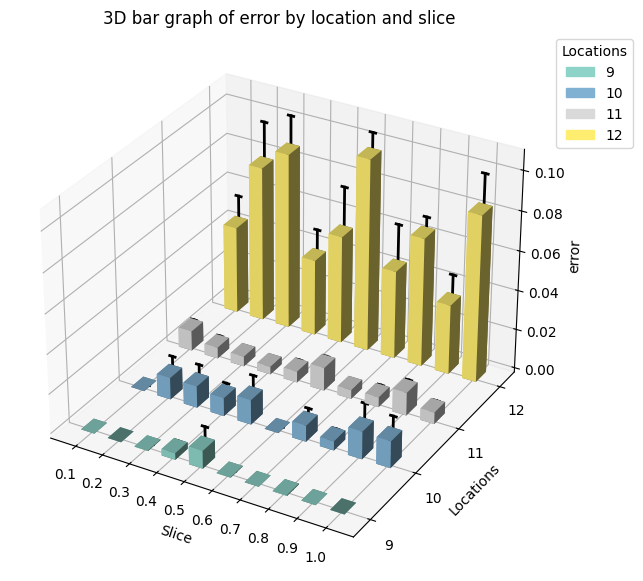

In [6]:
input = 'error'
plot_3d_graph_slice(sliced_summary, input, show_sem=True)

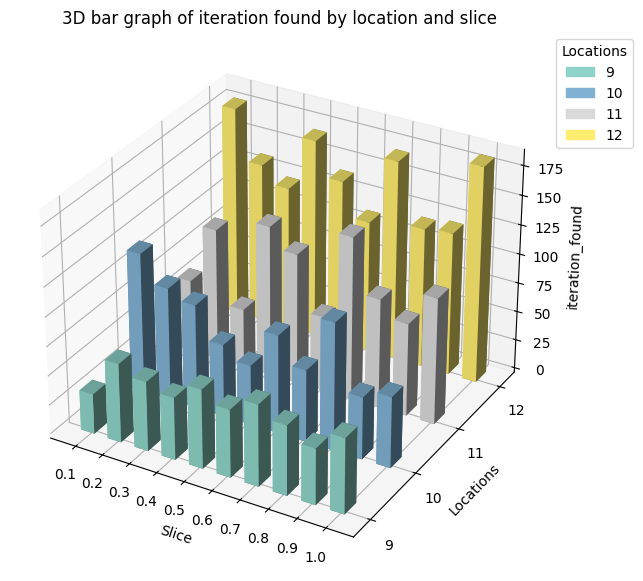

In [7]:
sliced_summary = grouped['iteration_found'].agg(
    mean='mean',
    sem='sem'
).reset_index()

sliced_summary = sliced_summary.rename(columns={'mean': 'iteration_found'})
sliced_summary.head()

input = 'iteration_found'
plot_3d_graph_slice(sliced_summary, input, show_sem=False)

## Analysis of different qml models


In [8]:
qml_mode = read_data()
qml_mode = qml_mode[(qml_mode['mode'] == 2)]
qml_mode = filter_results_qml(qml_mode)
qml_mode = find_quality(qml_mode, factor=100, round=1)
qml_mode = qml_mode[(qml_mode['slice'] == 0.8)]
qml_mode = qml_mode[['locations', 'slice','iteration_found', 
                     'best_dist_found', 'best_dist', 
                     'quality', 'error','mode',
                     'cache_misses', 'cache_hits']]
qml_mode_pivot = qml_mode.pivot_table(
        index='locations', 
        columns='mode', 
        values='quality',
        aggfunc=['mean', 'sem', 'count']
)
qml_mode_pivot = qml_mode_pivot.round(1)
print(qml_mode_pivot)

            mean  sem count
mode         2.0  2.0   2.0
locations                  
4          100.0  0.0    13
5          100.0  0.0    10
6          100.0  0.0    12
7          100.0  0.0    10
8          100.0  0.0    10
9          100.0  0.0    10
10          99.6  0.3    12
11          99.5  0.3     7
12          93.5  0.8    32


In [9]:
qml_mode_pivot2 = qml_mode.pivot_table(
        index = 'mode',
        values='quality',
        aggfunc=['mean', 'sem', 'count']
)
qml_mode_pivot2 = qml_mode_pivot2.round(1)
print(qml_mode_pivot2)

        mean     sem   count
     quality quality quality
mode                        
2.0     98.1     0.3     116


In [10]:
#calculate overall mean for each mode
qml_mode_summary = qml_mode_pivot.mean(axis=0).reset_index()
qml_mode_summary = qml_mode_summary.round(1)
print(qml_mode_summary)

  level_0  mode     0
0    mean   2.0  99.2
1     sem   2.0   0.2
2   count   2.0  12.9


### Evaluate cache hits

In [ ]:
qml_mode = qml_mode[(qml_mode['mode'] == 2)] # only interested in best case
qml_mode['total_cache_calls'] = qml_mode['cache_misses'] + qml_mode['cache_hits']
qml_mode['permutations'] = qml_mode['locations'].apply(lambda x: 0.5 * math.factorial(x - 1))
qml_mode['cover'] = qml_mode['total_cache_calls'] / qml_mode['permutations']


KeyError: 'monte_carlo'

In [ ]:
#pivot table for cache hits
qml_mode_pivot_cache = qml_mode.pivot_table(       
        index='locations', 
        columns='mode', 
        values=['cover','permutations', 'total_cache_calls'],
        aggfunc=['mean']
        )

print(qml_mode_pivot_cache)

## Analysis of ml models with different numbers of layers

In [ ]:
df = read_data()
df = filter_results_ml(df)
df = find_quality(df)
df = select_key_fields_ml(df)
df = df[(df['mode'] == 8)]
df['layers'] = df['layers'].astype(int)

In [ ]:
layers_summary = df.groupby(['layers','locations', ]).mean().reset_index()

In [ ]:
input = 'error'
plot_3d_graph_models(layers_summary, input)

In [ ]:
df['quality'] = df['quality']*100
ml_layer_pivot = df.pivot_table(
        index='locations', 
        columns='layers', 
        values='quality',
        aggfunc= ['mean', 'sem', 'count']
        )
ml_layer_pivot = ml_layer_pivot.round(1)
print(ml_layer_pivot)


In [ ]:
ml_layer_summary = ml_layer_pivot.mean(axis=0).reset_index()
ml_layer_summary = ml_layer_summary.round(1)
ml_layer_summary.head()

# Impact of hot start

### QML - hot start

In [ ]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df = df[(df['noise'] != True)]


df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'hot_start']]


In [ ]:
hot_qml_mean = df.groupby(['locations', 'hot_start',]).mean().reset_index()

In [ ]:
hot_qml_pivot = hot_qml_mean.pivot_table(
    index='locations', 
    columns='hot_start', 
    values='quality',
    aggfunc= ['mean', 'sem', 'count']
    )
hot_qml_pivot = hot_qml_pivot.round(1)
print(hot_qml_pivot)

In [ ]:
hot_qml_summary = hot_qml_pivot.mean(axis=0).reset_index()
hot_qml_summary.head()

### Classical ML - hot start

In [ ]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['mode'] == 8)]
df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'hot_start']]


In [ ]:
hot_ml_mean = df.groupby(['locations', 'hot_start',]).mean().reset_index()

In [ ]:
hot_ml_pivot = hot_ml_mean.pivot_table(
    index='locations', 
    columns='hot_start', 
    values='quality',
    aggfunc= ['mean', 'sem', 'count']
    )
hot_ml_pivot = hot_ml_pivot.round(1)
print(hot_ml_pivot)

In [ ]:
hot_ml_summary = hot_ml_pivot.mean(axis=0).reset_index()
hot_ml_summary.head()

## Impact of Gray encoding

### QML - Gray

In [ ]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df = df[(df['noise'] != True)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'gray']]

gray_mean_qml = df.groupby(['locations', 'gray',]).mean().reset_index()
if SHOW_COUNTS:
    gray_mean_qml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    gray_mean_qml = df.groupby(['locations', 'gray',]).mean().reset_index()
gray_qml_pivot = gray_mean_qml.pivot_table(index='locations', 
                                           columns='gray', 
                                           values='quality', 
                                           aggfunc= ['mean', 'sem', 'count'])
gray_qml_pivot = gray_qml_pivot.round(1)
print(gray_qml_pivot)


In [ ]:

gray_summary_qml = gray_qml_pivot.mean(axis=0).reset_index()
gray_summary_qml.head(20)

### Classical ML - Gray

In [ ]:

df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]
df = df[(df['mode'] == 8)]
df = df[(df['layers'] == 4)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'gray', ]]

if SHOW_COUNTS:
    gray_mean_ml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    gray_mean_ml = df.groupby(['locations', 'gray',]).mean().reset_index()

In [ ]:
gray_ml_pivot = gray_mean_ml.pivot_table(index='locations', columns='gray', values='quality')
gray_ml_pivot = gray_ml_pivot.round(1)
print(gray_ml_pivot)

In [ ]:
gray_summary_ml = gray_mean_ml.groupby(['gray',]).mean().reset_index()
gray_summary_ml.head(20)

## Impact of formalation

### QML - formulation

In [ ]:
df = read_data()
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df = df[(df['noise'] != True)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'formulation',]]

form_mean_qml = df.groupby(['locations', 'formulation',]).mean().reset_index()
if SHOW_COUNTS:
    form_mean_qml = df.groupby(['locations', 'formulation',]).count().reset_index()
else:
    form_mean_qml = df.groupby(['locations', 'formulation',]).mean().reset_index()
form_qml_pivot = form_mean_qml.pivot_table(index='locations', columns='formulation', values='quality')
form_qml_pivot = form_qml_pivot.round(1)
form_qml_pivot = form_qml_pivot.rename(columns={'original': 'non-factorial', 'new': 'factorial'})
print(form_qml_pivot)


In [ ]:
form_summary_qml = form_qml_pivot.mean(axis=0).reset_index()
form_summary_qml.head()

## Classical ML formulation

In [ ]:
df = read_data()
df = df[(df['gray'] == False)]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]
df = df[(df['mode'] == 8)]
df = df[(df['layers'] == 4)]
df = df[(df['locations'] < 26)]  #issue calculating large locations

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'formulation', ]]

if SHOW_COUNTS:
    form_mean_ml = df.groupby(['locations', 'formulation',]).count().reset_index()
else:
    form_mean_ml = df.groupby(['locations', 'formulation',]).mean().reset_index()

form_ml_pivot = form_mean_ml.pivot_table(index='locations', columns='formulation', values='quality')
form_ml_pivot = form_ml_pivot.round(1)
form_ml_pivot = form_ml_pivot.rename(columns={'original': 'non-factorial', 'new': 'factorial'})
print(form_ml_pivot)

In [ ]:
form_summary_ml = form_ml_pivot.mean(axis=0).reset_index()
form_summary_ml.head()

## Impact of changing minibatch size for ML

In [ ]:
SHOW_COUNTS = False
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['mode'] == 8)]
df = df[(df['shots'] != 2)]
#df = df[(df['shots'] == 1024)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]

df = find_quality(df, factor=100,)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'cache_misses', 'cache_hits']]

df["shots"] = df["shots"].round().astype(int)

shots_ml_pivot = df.pivot_table(index='locations', 
                                           columns='shots', 
                                           values='quality',
                                           aggfunc=['mean', 'sem', 'count',]
                                         )



shots_ml_pivot = shots_ml_pivot.round(1)

print(shots_ml_pivot)

In [ ]:
#input = 'error'
shots_mean_ml = df.groupby(['locations', 'shots',]).mean().reset_index()
plot_3d_graph_models(shots_mean_ml, 
                     input = 'error', 
                     input2='shots'), 

###  Cache hits


In [ ]:
#df = df[(df['shots'] == 1024)]
df['total_cache_calls'] = df['cache_misses'] + df['cache_hits']
df['permutations'] = df['locations' ].apply(lambda x: 0.5* math.factorial(x - 1))

df['coverage'] = df['total_cache_calls'] / df['permutations']
df.head()


cache_ml_pivot = df.pivot_table(index='locations', 
                                           columns='shots', 
                                           values=['total_cache_calls', 'permutations', 'coverage'],
                                           aggfunc=['mean', ]
                                         )

cache_ml_pivot = cache_ml_pivot.map(lambda x: format(x, ".3e"))                                  

print(cache_ml_pivot)

In [ ]:


shots_summary_ml = df.groupby(['shots',]).mean().reset_index()
shots_summary_ml.drop(columns=['locations'], inplace=True)
shots_summary_ml.drop(columns=['error'], inplace=True)
shots_summary_ml['elapsed'] = shots_summary_ml['elapsed'].astype(int)
shots_summary_ml['iteration_found'] = shots_summary_ml['iteration_found'].round(1)
shots_summary_ml['quality'] = shots_summary_ml['quality'].round(1)
print(shots_summary_ml.to_string(index=False))

## Impact of optimiser on Classical ML

In [ ]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'].isin([64, 256]))]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 4)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['gradient_type'] == 'SGD')]

df = find_quality(df, factor=100)

df_SGD = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'gradient_type']]

In [ ]:
df_SGD.head()

In [ ]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'].isin([64, 256]))]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 4)]
df = df[(df['lr'] == 0.001)]
df = df[(df['weight_decay'] == 0.0032)]
df = df[(df['gradient_type'] == 'Adam')]

df = find_quality(df, factor=100)

df_Adam = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'gradient_type']]

df_Adam.head()

In [ ]:
df_combined = pd.concat([df_SGD, df_Adam], ignore_index=True)
df_combined['quality'] = df_combined['quality'].round(1)

In [ ]:
if SHOW_COUNTS:
    optimiser_mean_ml = df_combined.groupby(['locations', 'lr', 'gradient_type', 'shots']).count().reset_index()
else:
    optimiser_mean_ml = df_combined.groupby(['locations', 'lr', 'gradient_type', 'shots']).mean().reset_index()

In [ ]:
optimiser_mean_ml = optimiser_mean_ml.round(1)
optimiser_mean_ml.head()

In [ ]:
optimiser_ml_pivot = optimiser_mean_ml.pivot_table(
    index='locations', 
    columns=['gradient_type', 'shots'], 
    values='quality',
    aggfunc= ['mean', 'sem', 'count']
    )
optimiser_ml_pivot = optimiser_ml_pivot.round(1)
print(optimiser_ml_pivot)

In [ ]:
optimiser_ml_summary_pivot = optimiser_mean_ml.pivot_table(
    index='gradient_type', 
    columns=['shots'], 
    values='quality',
    aggfunc='mean'  # or 'first', 'max', etc.
    )
optimiser_ml_summary_pivot = optimiser_ml_summary_pivot.round(1)
print(optimiser_ml_summary_pivot)

In [ ]:

optimiser_summary_ml = optimiser_mean_ml.pivot_table(index='gradient_type', values='quality')
optimiser_summary_ml.head()

### Adam hyperparameter training

In [ ]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'] == 64)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 4)]
df = df[(df['locations'] == 12)]
df =df[df['gradient_type'] == 'Adam']
df = find_quality(df, factor=100)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'momentum', ]]

In [ ]:
if SHOW_COUNTS:
    adam_mean_ml = df.groupby(['lr', 'weight_decay']).count().reset_index()
else:
    adam_mean_ml = df.groupby(['lr', 'weight_decay']).mean().reset_index()
adam_mean_ml.head()

In [ ]:
adam_summary_ml = adam_mean_ml.pivot_table(index='lr', columns = 'weight_decay', values='quality')
plot_heatmap(adam_summary_ml, 
             'Adam Optimiser Heatmap',
             'Weight Decay', 
             'Learning Rate', 
             )


## SGD hyper parameter training

In [ ]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'] == 64)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 2)]
df = df[(df['locations'] == 10)]
df =df[df['gradient_type'] == 'SGD']
df =df[df['mode'] == 8]
df = find_quality(df, factor=100)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'momentum', 'layers']]

In [ ]:
df = df[(df['momentum'] == 0.8)]
if SHOW_COUNTS:
    SGD_mean_ml = df.groupby(['lr', 'weight_decay']).count().reset_index()
else:
    SGD_mean_ml = df.groupby(['lr', 'weight_decay']).mean().reset_index()
SGD_mean_ml.head()

In [ ]:
SGD_summary_ml = SGD_mean_ml.pivot_table(index='lr', columns = 'weight_decay', values='quality')
plot_heatmap(SGD_summary_ml, 
             'SGD Optimiser Heatmap',
             'Weight Decay', 
             'Learning Rate', 
             )

## ML initialisation with different values

In [ ]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['gradient_type'] == 'SGD')]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 256


)]
df = df[(df['layers'] == 4)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'gray', ]]

if SHOW_COUNTS:
    mode_mean_ml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    mode_mean_ml = df.groupby(['locations', 'gray',]).mean().reset_index()

mode_mean_ml.head()

In [ ]:
mode_ml_pivot = df.pivot_table(
    index='locations', 
    columns=['mode'], 
    values='quality',
    aggfunc= ['mean', 'sem', 'count']
    )
mode_ml_pivot = mode_ml_pivot.round(1)
print(mode_ml_pivot)

In [ ]:
mode_summary_ml_pivot = mode_ml_pivot.mean(axis=0).reset_index()
mode_summary_ml_pivot = mode_summary_ml_pivot.round(1)
mode_summary_ml_pivot.head(10)



## Noise

In [ ]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]
df = df[(df['shots'] == 1024)]
df = df[(df['mode'] == 2)]

df['noise'] = df['noise'].fillna(False)
pd.set_option('future.no_silent_downcasting', True)
df = df[(df['noise'] == True)]

df = find_quality(df, factor=100)

In [ ]:
noise_qml_pivot = df.pivot_table(
    index='locations', 
    columns = ['noise', 'iterations',],
    values= ['quality', 'elapsed',],
    aggfunc= ['mean', ],
    )
noise_qml_pivot = noise_qml_pivot.round(1)
print(noise_qml_pivot)

## Iterations required

In [ ]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]
df = df[(df['shots'] == 1024)]
df = df[(df['mode'] == 2)]


df = find_quality(df, factor=100)

In [ ]:
iterations_qml_pivot = df.pivot_table(
    index = 'locations',
    columns = [],
    values= ['quality','iteration_found' ],
    aggfunc= ['mean', ],
    )
iterations_qml_pivot = iterations_qml_pivot.round(1)
print(iterations_qml_pivot)